# MODELO ARIMA - SARIMAX
Irene Pico López <br>

*Adaptación a partir de:* <br>
Modelos ARIMA y SARIMAX con Python por Joaquín Amat Rodrigo y Javier Escobar Ortiz, disponible con licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py51-modelos-arima-sarimax-python.html

In [1]:
# Librerías
#######################
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# pmdarima
from pmdarima import auto_arima
import warnings

print(f"Versión statsmodels: {statsmodels.__version__}")

Versión statsmodels: 0.14.2


## 1. Datos
Cargamos los datos que previamente habíamos guardado.

In [2]:
# Cargar los datos desde un archivo HDF5
ibex35 = pd.read_hdf('ibex35.h5', key='datos_tratados')

# Guardamos los datos de precios de cierre en un DataFrame de Pandas
datos = pd.DataFrame(ibex35['adj_close'])
datos

,adj_close
Date,
2010-04-01,11067.889648
2010-04-06,11160.587891
2010-04-07,11191.288086
2010-04-08,11076.289062
2010-04-09,11394.188477
...,...
2024-07-25,11145.599609
2024-07-26,11165.900391
2024-07-29,11117.799805


Fechas train : 2010-04-01 00:00:00 --- 2023-12-29 00:00:00  (n=3517)
Fechas test 1 : 2024-01-02 00:00:00 --- 2024-01-31 00:00:00  (n=22)
Fechas test 2 : 2024-01-02 00:00:00 --- 2024-03-28 00:00:00  (n=63)
Fechas test 3 : 2024-01-02 00:00:00 --- 2024-07-31 00:00:00  (n=149)


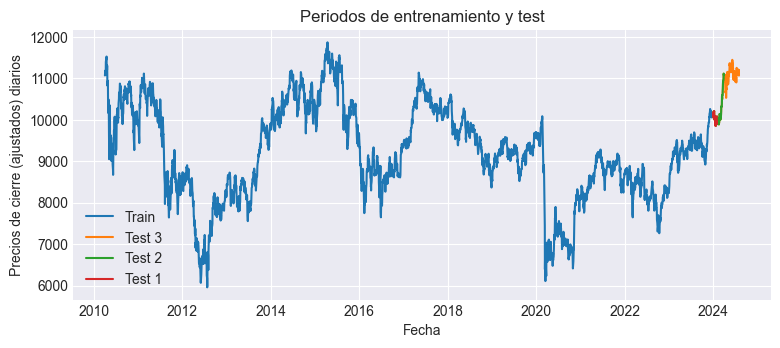

In [3]:
# Fechas Train-test
# #######################
fin_train = '2023-12-31'
fin_test1 = '2024-01-31'
fin_test2 = '2024-03-31'
print(
    f"Fechas train : {datos.index.min()} --- {datos.loc[:fin_train].index.max()}  "
    f"(n={len(datos.loc[:fin_train])})"
)
print(
    f"Fechas test 1 : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_test1].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_test1])})"
)
print(
    f"Fechas test 2 : {datos.loc[fin_train:].index.min()} --- {datos.loc[:fin_test2].index.max()}  "
    f"(n={len(datos.loc[fin_train:fin_test2])})"
)
print(
    f"Fechas test 3 : {datos.loc[fin_train:].index.min()} --- {datos.loc[:].index.max()}  "
    f"(n={len(datos.loc[fin_train:])})"
)
datos_train = datos.loc[:fin_train]
datos_test1  = datos.loc[fin_train:fin_test1]
datos_test2  = datos.loc[fin_train:fin_test2]
datos_test3  = datos.loc[fin_train:]

# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))

# Usar matplotlib directamente para más control sobre las etiquetas
ax.plot(datos_train.index, datos_train['adj_close'], label='Train')
ax.plot(datos_test3.index, datos_test3['adj_close'], label='Test 3')
ax.plot(datos_test2.index, datos_test2['adj_close'], label='Test 2')
ax.plot(datos_test1.index, datos_test1['adj_close'], label='Test 1')

# Títulos y etiquetas de los ejes
ax.set_title('Periodos de entrenamiento y test')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precios de cierre (ajustados) diarios')
# Mostrar leyenda
ax.legend()
# Mostrar el gráfico
plt.show()

## 2. Análisis de la serie
Para crear un modelo ARIMA es necesario estudiar 3 factores clave:
* Estacionariedad
* Autorrelación
* Descomposición estacional

### 2.1. Estacionariedad

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -3.27431788445924, p-value: 0.016066229366662833
KPSS Statistic: 0.5800091214830759, p-value: 0.024453716228811276

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -57.47934487833923, p-value: 0.0
KPSS Statistic: 0.09332203574957308, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -19.246187186939068, p-value: 0.0
KPSS Statistic: 0.03267932469644581, p-value: 0.1


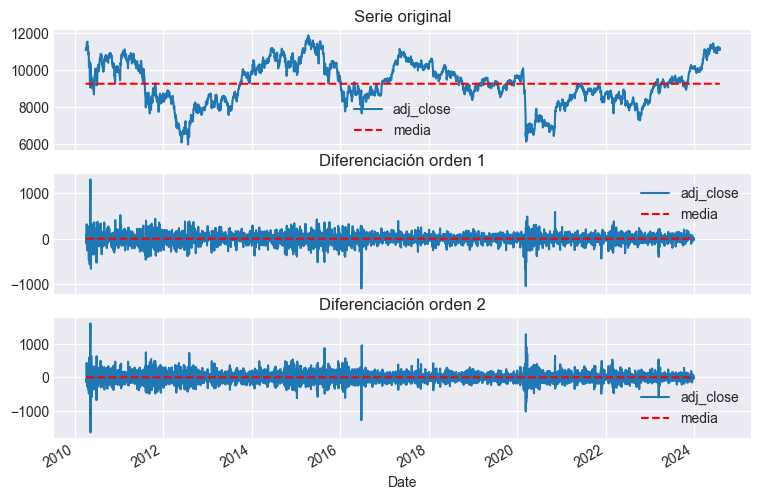

In [4]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos_train.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
# Calculo de las medias
media_datos = np.mean(datos)
media_datos_diff_1 = np.mean(datos_diff_1)
media_datos_diff_2 = np.mean(datos_diff_2)
# Crear listas de medias con la misma longitud que las series originales
media_datos_list = [media_datos] * len(datos)
media_datos_diff_1_list = [media_datos_diff_1] * len(datos_diff_1)
media_datos_diff_2_list = [media_datos_diff_2] * len(datos_diff_2)

#####
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 6), sharex=True)
# Serie original
datos.plot(ax=axs[0], title='Serie original')
axs[0].plot(datos.index, media_datos_list, color='red', linestyle='--', label='media')
axs[0].legend()

# Diferenciación orden 1
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
axs[1].plot(datos_diff_1.index, media_datos_diff_1_list, color='red', linestyle='--', label='media')
axs[1].legend()

# Diferenciación orden 2
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2')
axs[2].plot(datos_diff_2.index, media_datos_diff_2_list, color='red', linestyle='--', label='media')
axs[2].legend()

plt.show()

* H0: serie no estacionaria
* H1: serie estacionaria

A la vista del p-valor y suponiendo un alpha del 0.05, podemos concluir que la serie diferencia 1 vez (d=1) es estacionaria en media. Por lo tanto, la selección más adecuada para el parámetro ARIMA *d* es 1.

### 2.2. Autocorrelación

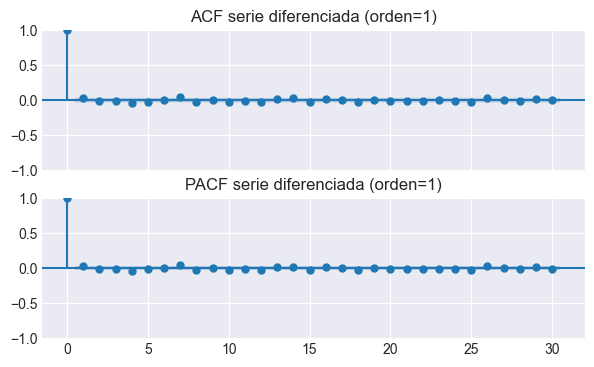

In [5]:
# ACF y PACF de la serie diferenciada (d=1)
######################################################################
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
## ACF
plot_acf(datos_diff_1, ax=axs[0], lags=30, alpha=0.05)
axs[0].set_title('ACF serie diferenciada (orden=1)');
## PACF
plot_pacf(datos_diff_1, ax=axs[1], lags=30, alpha=0.05)
axs[1].set_title('PACF serie diferenciada (orden=1)');

Los gráficos no sugieren ninguna estructura autorrregresiva (AR) ni de media móvil (MA), pues no se observa ningún retardo significativo posterior al 0.

### 2.3. Descomposición estacional

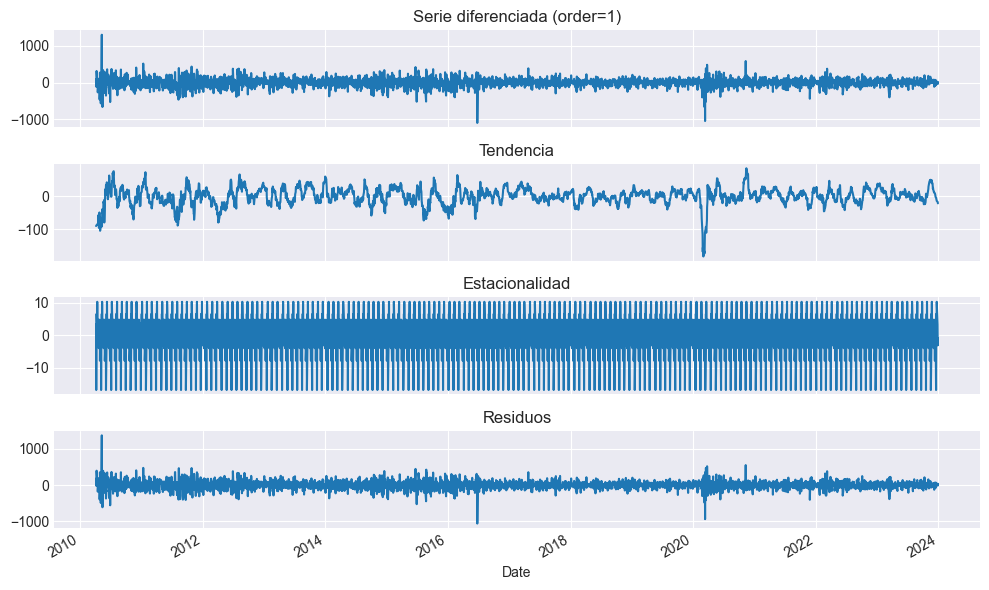

In [6]:
# Descomposición de la serie diferenciada
###################################################

# Asegurar que el índice tenga una frecuencia establecida
datos_diff_1 = datos_diff_1.asfreq('D').dropna()
# Especificar el periodo manualmente
res_descompose_diff_1 = seasonal_decompose(datos_diff_1, model='additive', period=21, extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)

res_descompose_diff_1.observed.plot(ax=axs[0])
axs[0].set_title('Serie diferenciada (order=1)')
res_descompose_diff_1.trend.plot(ax=axs[1])
axs[1].set_title('Tendencia')
res_descompose_diff_1.seasonal.plot(ax=axs[2])
axs[2].set_title('Estacionalidad')
res_descompose_diff_1.resid.plot(ax=axs[3])
axs[3].set_title('Residuos')

fig.tight_layout()
plt.show()

In [7]:
# Diferenciaciación de orden 1 combinada con diferenciación estacional
# #######################################################################
datos_diff_1_D = datos_train.diff().diff(21).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_D)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_D)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -20.924659901272232, p-value: 0.0
KPSS Statistic: 0.006938061264830506, p-value: 0.1


ADF:

* H0: serie no estacionaria
* H1: serie estacionaria

=> p-valor < alpha (0.05), se rechaza H0.

KPSS:

* H0: serie estacionaria
* H1: serie no estacionaria

=> p-valor > alpha (0.05), no se rechaza H0.

La serie sigue siendo estacionaria aplicando una diferencia mensual (21 días).

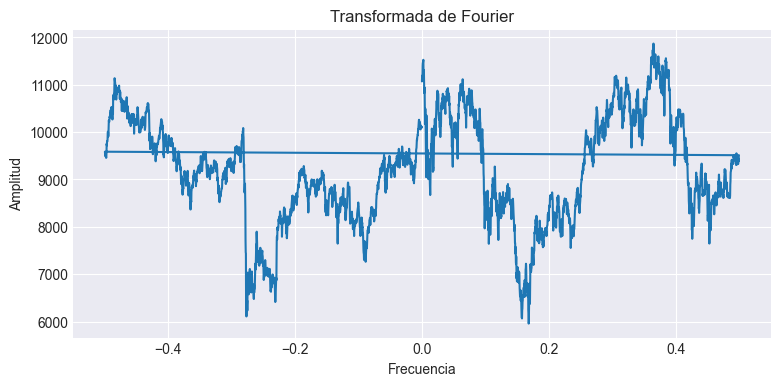

In [8]:
## FFT (Transformada Rápida de Fourier) --> para analizar composición de frecuencia (identificar patrones)
import numpy as np

fft = np.fft.fft(datos_train)
frequencies = np.fft.fftfreq(len(fft))

plt.figure(figsize=(9, 4))
plt.plot(frequencies, np.abs(fft))
plt.title('Transformada de Fourier')
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.show()


No se observan patrones estacionales claros.

## 3. Automatización del proceso de construcción del modelo
Ante los malos resultados al intentar construir el modelo ARIMA basándonos en el análisis gráfico, se ha optado por emplear una función que optimice automáticamente los parámetros a seleccionar.

In [9]:
warnings.filterwarnings("ignore")
# Optimización automática del modelo SARIMAX
modelo_opt = auto_arima(datos_train,
                        seasonal=True,
                        m=21,  # Estacionalidad de 21 días
                        stepwise=True,  # Acelerar el proceso de búsqueda
                        suppress_warnings=True,  # Suprimir advertencias para claridad
                        start_p=0, max_p=2,  # Rango de búsqueda para el parámetro p (AR)
                        start_q=0, max_q=2,  # Rango de búsqueda para el parámetro q (MA)
                        start_P=0, max_P=0,  # parámetro P (estacional AR)
                        start_Q=0, max_Q=0,  # parámetro Q (estacional MA)
                        d=1,  # Orden de diferenciación no estacional
                        D=1,  # Orden de diferenciación estacional
                        n_jobs=1,  # Ejecutar un trabajo a la vez
                        trace=True)  # Mostrar el progreso de la búsqueda

print(f"Parámetros óptimos encontrados:")
print(f"order: {modelo_opt.order}")
print(f"seasonal_order: {modelo_opt.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[21]             : AIC=45902.633, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[21]             : AIC=45899.339, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[21]             : AIC=45899.408, Time=0.31 sec
 ARIMA(2,1,0)(0,1,0)[21]             : AIC=45900.810, Time=0.37 sec
 ARIMA(1,1,1)(0,1,0)[21]             : AIC=45900.380, Time=0.93 sec
 ARIMA(2,1,1)(0,1,0)[21]             : AIC=45901.461, Time=1.29 sec
 ARIMA(1,1,0)(0,1,0)[21] intercept   : AIC=45901.324, Time=0.82 sec

Best model:  ARIMA(1,1,0)(0,1,0)[21]          
Total fit time: 4.427 seconds
Parámetros óptimos encontrados:
order: (1, 1, 0)
seasonal_order: (0, 1, 0, 21)


## 4. Predicciones

In [10]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore")
modelo = SARIMAX(endog = datos_train, order = (1, 1, 0), seasonal_order=(0, 1, 0, 21))
modelo_res = modelo.fit(disp=0)

# Predicción statsmodels para los tres escenarios de predicción
# ==============================================================================
# Escenario 1: datos_test1
predicciones_statsmodels_test1 = modelo_res.get_forecast(steps=len(datos_test1)).predicted_mean
predicciones_statsmodels_test1.name = 'predicciones_statsmodels_test1'
display(predicciones_statsmodels_test1.head(4))
print('\n')

# Escenario 2: datos_test2
predicciones_statsmodels_test2 = modelo_res.get_forecast(steps=len(datos_test2)).predicted_mean
predicciones_statsmodels_test2.name = 'predicciones_statsmodels_test2'
display(predicciones_statsmodels_test2.head(4))
print('\n')

# Escenario 3: datos_test3
predicciones_statsmodels_test3 = modelo_res.get_forecast(steps=len(datos_test3)).predicted_mean
predicciones_statsmodels_test3.name = 'predicciones_statsmodels_test3'
display(predicciones_statsmodels_test3.head(4))

3517    10159.299040
3518    10154.821823
3519    10237.418406
3520    10274.918288
Name: predicciones_statsmodels_test1, dtype: float64

3517    10159.299040
3518    10154.821823
3519    10237.418406
3520    10274.918288
Name: predicciones_statsmodels_test2, dtype: float64

3517    10159.299040
3518    10154.821823
3519    10237.418406
3520    10274.918288
Name: predicciones_statsmodels_test3, dtype: float64

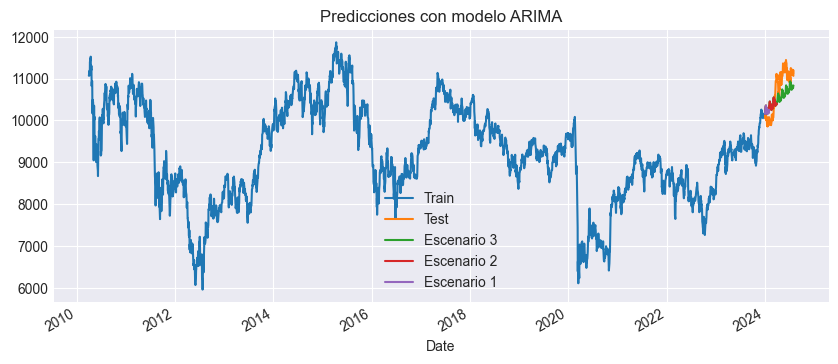

In [14]:
# Plot predictions
# ==============================================================================
## Cambio índices
predicciones_statsmodels_test1.index = datos_test1.index
predicciones_statsmodels_test2.index = datos_test2.index
predicciones_statsmodels_test3.index = datos_test3.index
## Gráfico
fig, ax = plt.subplots(figsize=(10, 4))
datos_train['adj_close'].plot(ax=ax, label='Train')
datos_test3['adj_close'].plot(ax=ax, label='Test')
predicciones_statsmodels_test3.plot(ax=ax, label='Escenario 3')
predicciones_statsmodels_test2.plot(ax=ax, label='Escenario 2')
predicciones_statsmodels_test1.plot(ax=ax, label='Escenario 1')
ax.set_title('Predicciones con modelo ARIMA')
ax.legend();

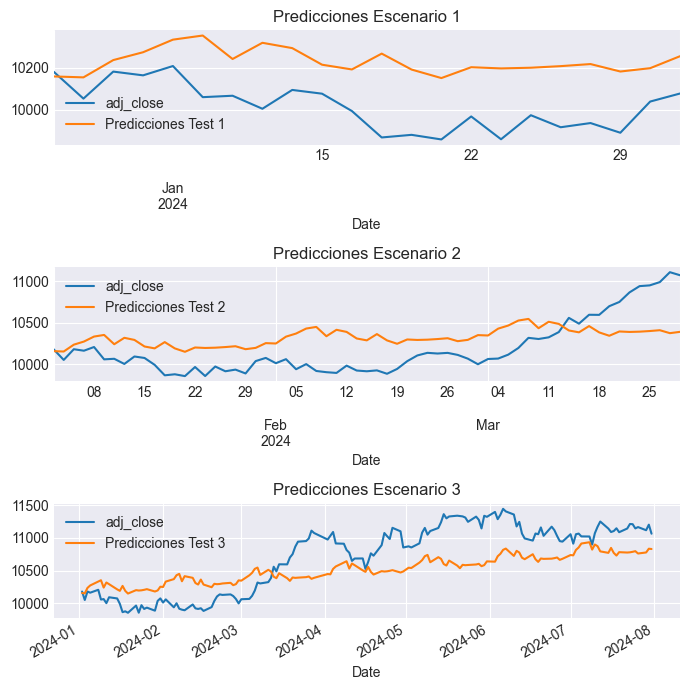

In [12]:
# Crear una figura con tres subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 7))

# Escenario 1
predicciones_statsmodels_test1.index = datos_test1.index
datos_test1.plot(ax=axes[0], label='Adj Close')
predicciones_statsmodels_test1.plot(ax=axes[0], label='Predicciones Test 1')
axes[0].set_title('Predicciones Escenario 1')
axes[0].legend()

# Escenario 2
predicciones_statsmodels_test2.index = datos_test2.index
datos_test2.plot(ax=axes[1], label='Datos de prueba (Test 2)')
predicciones_statsmodels_test2.plot(ax=axes[1], label='Predicciones Test 2')
axes[1].set_title('Predicciones Escenario 2')
axes[1].legend()

# Escenario 3
predicciones_statsmodels_test3.index = datos_test3.index
datos_test3.plot(ax=axes[2], label='Datos de prueba (Test 3)')
predicciones_statsmodels_test3.plot(ax=axes[2], label='Predicciones Test 3')
axes[2].set_title('Predicciones Escenario 3')
axes[2].legend()

# Ajustar el espacio entre los subplots para que no se superpongan los títulos y etiquetas
plt.tight_layout()

# Mostrar la figura combinada
plt.show()


## 5. Métricas de validación

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Asegurarse de que las predicciones y los datos de prueba tienen el mismo índice
predicciones_statsmodels_test2.index = datos_test2.index

# Calcular métricas para predicciones de statsmodels
## ESCENARIO 1
mae_statsmodels = mean_absolute_error(datos_test1, predicciones_statsmodels_test1)
mse_statsmodels = mean_squared_error(datos_test1, predicciones_statsmodels_test1)
rmse_statsmodels = np.sqrt(mse_statsmodels)
print("Métricas de validación (Escenario 1):")
print(f"MAE: {mae_statsmodels:.4f}")
print(f"MSE: {mse_statsmodels:.4f}")
print(f"RMSE: {rmse_statsmodels:.4f}")
print('\n')

## ESCENARIO 2
mae_statsmodels = mean_absolute_error(datos_test2, predicciones_statsmodels_test2)
mse_statsmodels = mean_squared_error(datos_test2, predicciones_statsmodels_test2)
rmse_statsmodels = np.sqrt(mse_statsmodels)
print("Métricas de validación (Escenario 2):")
print(f"MAE: {mae_statsmodels:.4f}")
print(f"MSE: {mse_statsmodels:.4f}")
print(f"RMSE: {rmse_statsmodels:.4f}")
print('\n')

## ESCENARIO 3
mae_statsmodels = mean_absolute_error(datos_test3, predicciones_statsmodels_test3)
mse_statsmodels = mean_squared_error(datos_test3, predicciones_statsmodels_test3)
rmse_statsmodels = np.sqrt(mse_statsmodels)
print("Métricas de validación (Escenario 3):")
print(f"MAE: {mae_statsmodels:.4f}")
print(f"MSE: {mse_statsmodels:.4f}")
print(f"RMSE: {rmse_statsmodels:.4f}")

Métricas de validación (Escenario 1):
MAE: 215.8042
MSE: 55892.9704
RMSE: 236.4169


Métricas de validación (Escenario 2):
MAE: 293.2358
MSE: 108634.1610
RMSE: 329.5970


Métricas de validación (Escenario 3):
MAE: 364.5409
MSE: 167609.2443
RMSE: 409.4011
